<a href="https://colab.research.google.com/github/KarissaChan1/rocket-nuggets/blob/main/SimpleRNN_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('.../GE.csv')
df = df[['Open','High','Low','Close']]
print(df)

df_array = df.to_numpy()
print(df_array.shape)

            Open        High         Low       Close
0     138.076920  139.461533  137.153839  138.307693
1     138.076920  139.000000  136.153839  137.153839
2     139.615387  140.384613  137.230774  139.615387
3     141.384613  141.384613  139.615387  139.923080
4     141.076920  142.307693  139.153839  139.384613
...          ...         ...         ...         ...
1254   85.980003   87.099998   85.669998   85.830002
1255   86.540001   87.620003   86.220001   87.139999
1256   86.830002   86.930000   84.650002   84.900002
1257   83.750000   85.769997   83.209999   85.389999
1258   86.489998   87.150002   84.849998   85.480003

[1259 rows x 4 columns]
(1259, 4)


In [ ]:
w=20 # using a window size of 20 (sequence length)
window_size=w

N = df_array.shape[0]*df_array.shape[1]
flattened = np.reshape(df_array,N,)
print(flattened.shape)

(5036,)


Using Lazy Window: we are creating sequences of size 20 for every 20 time points

In [ ]:
# get array size divisible by window size
input_size = 1  # Number of entries per time slot

m = int(np.floor(N/w))
print(m)

N2 = w*m
flattened = np.asarray(flattened).astype('float32')
new_flattened = flattened[0:N2]
print(new_flattened.shape[0])

zind=np.arange(0,N2,w)
z=new_flattened[zind]
print(z.shape)
x=np.reshape(new_flattened,(m,w,input_size))
print(x.shape)

251
5020
(251,)
(251, 20, 1)


In [ ]:
import torch 

n_train = int(x.shape[0]*0.75)
xtrain=torch.Tensor(x[0:n_train])
xtest=torch.Tensor(x[n_train:x.shape[0]])
ztrain=torch.Tensor(z[0:n_train])
ztest=torch.Tensor(z[n_train:x.shape[0]])
print(xtrain.size())
ztrain = np.reshape(ztrain,(188,1))
print(ztrain.size())
print(xtest.size())
ztest = np.reshape(ztest,(63,1))
print(ztest.size())

torch.Size([188, 20, 1])
torch.Size([188, 1])
torch.Size([63, 20, 1])
torch.Size([63, 1])


Create RNN Model

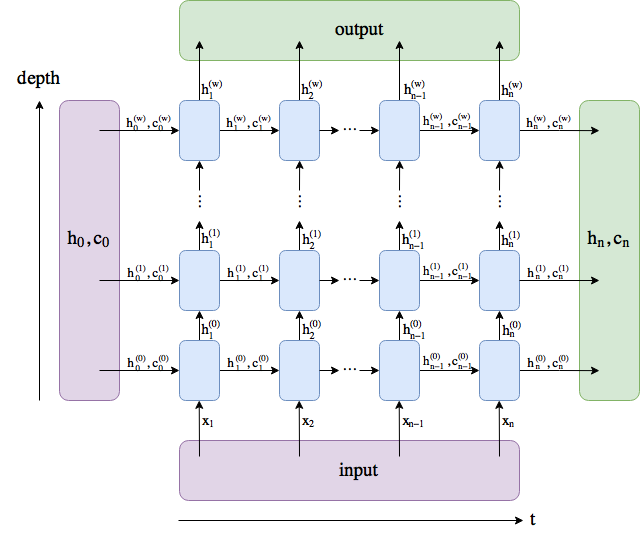

In [ ]:
from torch import nn

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.linear(output[:, -1, :])
        return output


In [ ]:
# Define the hyperparameters

hidden_size = 200
output_size = 1

# Create an instance of the model
model = RNN(input_size, output_size, hidden_size, n_layers= 2)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# nn.RNN module expects input size of (sequence_length (window size), batch_size (# of samples), input_size (number of entries per time slot))
n_epochs = 20
batch_size = 1
for epoch in range(n_epochs):
    # Shuffle the training data (optional)
    indices = torch.randperm(xtrain.size(0))
    xtrain = xtrain[indices]
    ztrain = ztrain[indices]

    # Iterate over mini-batches
    for i in range(0, xtrain.size(0), batch_size):
        # Extract mini-batches
        inputs = xtrain[i:i+batch_size]
        targets = ztrain[i:i+batch_size]

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training progress
    print('Epoch: {}/{} | Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

Epoch: 1/20 | Loss: 335.3179
Epoch: 2/20 | Loss: 1926.7151
Epoch: 3/20 | Loss: 2.4453
Epoch: 4/20 | Loss: 6.9582
Epoch: 5/20 | Loss: 96.3951
Epoch: 6/20 | Loss: 199.2493
Epoch: 7/20 | Loss: 593.3242
Epoch: 8/20 | Loss: 2.0051
Epoch: 9/20 | Loss: 148.2924
Epoch: 10/20 | Loss: 9.9145
Epoch: 11/20 | Loss: 1054.5745
Epoch: 12/20 | Loss: 55.2045
Epoch: 13/20 | Loss: 891.4338
Epoch: 14/20 | Loss: 147.1126
Epoch: 15/20 | Loss: 2.1590
Epoch: 16/20 | Loss: 33.6718
Epoch: 17/20 | Loss: 24.4464
Epoch: 18/20 | Loss: 7.3972
Epoch: 19/20 | Loss: 54.4040
Epoch: 20/20 | Loss: 64.7598


In [ ]:
def predict(model, x):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(x)
    return output

# Perform prediction using the trained model
predictions = predict(model, xtest)
print(predictions.size())

torch.Size([63, 1])


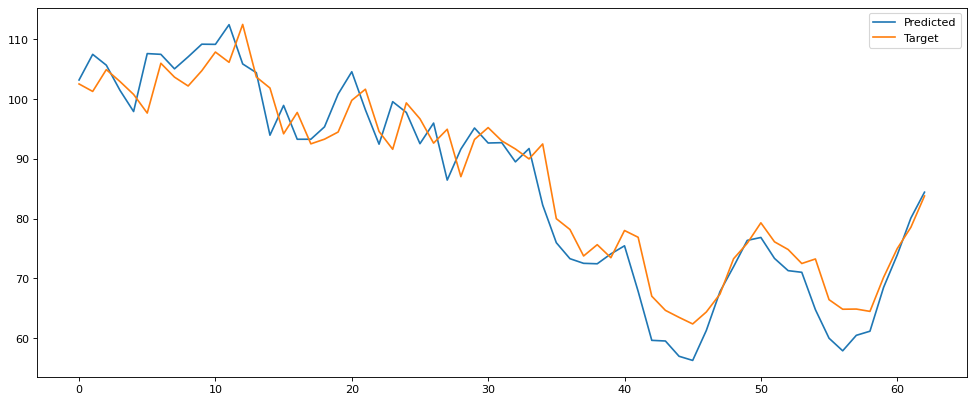

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(predictions)
plt.plot(ztest)
plt.legend(['Predicted','Target'])

Using Proper Window: instead of skipping through the series in windows of 20, we are now sliding the window of 20 through each data point.

In [ ]:
zind=np.arange(20,N2)
z=new_flattened[zind]
print(z.shape)

x = np.empty([new_flattened.shape[0]-w,w,1])
for n in range(0,new_flattened.shape[0]-w):
  sequence = new_flattened[n:n+w]
  x[n,] = sequence.reshape((20,1))

print(x.shape)

(5000,)
(5000, 20, 1)


In [ ]:
n_train = int(x.shape[0]*0.75)
xtrain=torch.Tensor(x[0:n_train])
xtest=torch.Tensor(x[n_train:x.shape[0]])
ztrain=torch.Tensor(z[0:n_train])
ztest=torch.Tensor(z[n_train:x.shape[0]])
print(xtrain.size())
ztrain = np.reshape(ztrain,(xtrain.size()[0],1))
print(ztrain.size())
print(xtest.size())
ztest = np.reshape(ztest,(xtest.size()[0],1))
print(ztest.size())

torch.Size([3750, 20, 1])
torch.Size([3750, 1])
torch.Size([1250, 20, 1])
torch.Size([1250, 1])


In [ ]:
# Define the hyperparameters
input_size = 1  # Number of entries per time slot
window_size = 20  # sequence length
hidden_size = 200
output_size = 1

# Create an instance of the model
model = RNN(input_size, output_size, hidden_size, n_layers= 2)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 20
batch_size = 1
for epoch in range(n_epochs):
    # Shuffle the training data (optional)
    indices = torch.randperm(xtrain.size(0))
    xtrain = xtrain[indices]
    ztrain = ztrain[indices]

    # Iterate over mini-batches
    for i in range(0, xtrain.size(0), batch_size):
        # Extract mini-batches
        inputs = xtrain[i:i+batch_size]
        targets = ztrain[i:i+batch_size]

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training progress
    print('Epoch: {}/{} | Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

Epoch: 1/20 | Loss: 255.8186
Epoch: 2/20 | Loss: 103.5338
Epoch: 3/20 | Loss: 0.1671
Epoch: 4/20 | Loss: 4.1102
Epoch: 5/20 | Loss: 11.8021
Epoch: 6/20 | Loss: 0.2217
Epoch: 7/20 | Loss: 0.3855
Epoch: 8/20 | Loss: 20.9305
Epoch: 9/20 | Loss: 0.3893
Epoch: 10/20 | Loss: 17.9406
Epoch: 11/20 | Loss: 12.9148
Epoch: 12/20 | Loss: 0.7919
Epoch: 13/20 | Loss: 0.1999
Epoch: 14/20 | Loss: 6.0337
Epoch: 15/20 | Loss: 3.5228
Epoch: 16/20 | Loss: 0.7224
Epoch: 17/20 | Loss: 15.6845
Epoch: 18/20 | Loss: 8.3771
Epoch: 19/20 | Loss: 4.5947
Epoch: 20/20 | Loss: 412.7188


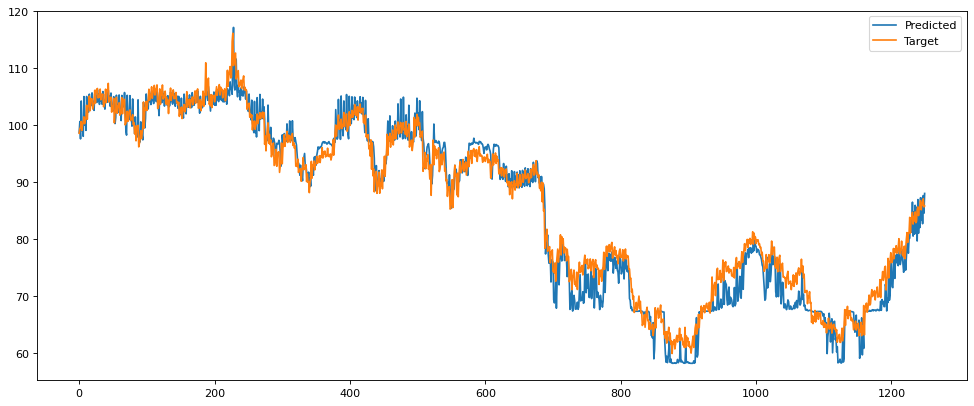

In [ ]:
predictions = predict(model,xtest)

plt.figure(figsize=(15, 6), dpi=80)
plt.plot(predictions[0:])
plt.plot(ztest)
plt.legend(['Predicted','Target'])